# BM 336546 - HW2: Type 1 Diabetes (T1D)
Our goal is to predict if a patient suffers from T1D, by applying ML algorithms on the given dataset. 


### 1) Loading the data

Let's start the assignment by loading the data and explain any preprocessing.

Loading the data:

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import random
%reload_ext autoreload

file = Path.cwd().joinpath('HW2_data.csv') # concatenates HW2_data.csv to the current folder
T1D_dataset = pd.read_csv(file) # load the data

random.seed(10)  # fill your seed number here
print('hello')

hello


Now we can apply some preprocessing. We decided to fill the empty cells (nan) with random values from each column.

In [2]:
from helpers_function import nan2rand_val as rv

filled_dataset = rv(T1D_dataset)

### 2) Splitting the data


Now we will split our dataset into a train (80%) and test (20%) sets, using the sklearn function. We would like our sets to represent equally the classes (diagnosis yes or no) of the patients, therefore we will use the stratify method with the diagnosis column.

In [3]:
from sklearn.model_selection import train_test_split
X = filled_dataset.loc[:, 'Age':'Obesity']
X['Family History']=filled_dataset[['Family History']]
list_features = list(X.columns.values)
Y = T1D_dataset[['Diagnosis']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)

### 3) Visualizating the data

#### a. Repartition in test/train
First, let's plot a table showing the repartition of positive features (as the features have a binary result) in each set (train and test)

In [4]:
import matplotlib.pyplot as plt
fts = ['Muscle Stiffness', 'Hair Loss', 'Obesity', 'Partial Paresis', 'Delayed Healing']

partition_ft = pd.DataFrame(columns=['Positive Feature','% in train','% in test','difference'])

partition_ft['Positive Feature'] = fts
train_lst = []
test_lst = []
for ft in fts:
    pos_ft_train = np.sum(X_train[[ft]]=='Yes')
    train_lst.append(100*pos_ft_train/len(X_train[[ft]]))
    pos_ft_test = np.sum(X_test[[ft]]=='Yes')
    test_lst.append(100*pos_ft_test/len(X_test[[ft]]))
partition_ft[['% in train']] = train_lst
partition_ft[['% in test']] = test_lst
partition_ft[['difference']] = np.array(train_lst) - np.array(test_lst)
print(partition_ft)


   Positive Feature % in train % in test difference
0  Muscle Stiffness    37.6106   33.6283     3.9823
1         Hair Loss    34.5133    40.708   -6.19469
2           Obesity    17.2566   15.0442    2.21239
3   Partial Paresis     44.469   35.3982     9.0708
4   Delayed Healing    45.7965   47.7876   -1.99115


As we can notice, the difference between the percentage of positive features in the train and in the test set is lower than 10% (in absolute value). Hence, we can conclude that the data is distributed similarly in both sets (train and test).

An imbalance of features between train and test sets could cause a bad interpretation of the dataset; if in the train set, we have a lot more positive values ('Yes') for a specific feature, the model trained on it will be fitted accordingly (will be very accurate for that positive feature), but not taking in consideration the negative values ('No'), that we will surely interpret wrongly in the test set.

In order to solve such an issue, we can for example split the dataset using stratification (meaning taking in consideration the ratios for specific features).#more data

#### b. Relationship between features and label

We will now plot the relationship between features and label:

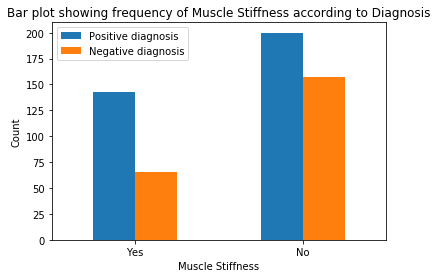

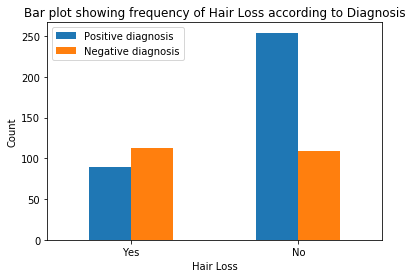

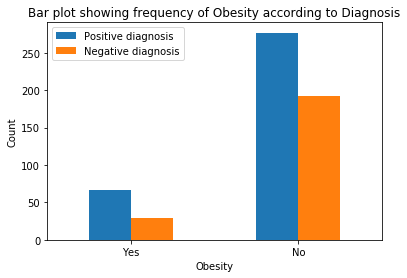

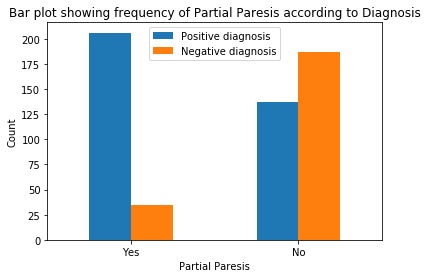

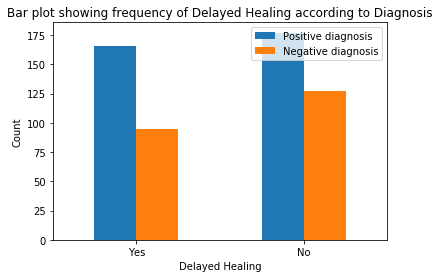

In [5]:
for ft in fts:
    DiagYesFt = filled_dataset[ft].loc[filled_dataset['Diagnosis'] == 'Positive']
    DiagYesFtYes = np.sum(DiagYesFt == 'Yes')
    DiagYesFtNo = np.sum(DiagYesFt == 'No')

    DiagNoFt = filled_dataset[ft].loc[filled_dataset['Diagnosis'] == 'Negative']
    DiagNoFtYes = np.sum(DiagNoFt == 'Yes')
    DiagNoFtNo = np.sum(DiagNoFt == 'No')
    DiagYes = [DiagYesFtYes, DiagYesFtNo]
    DiagNo = [DiagNoFtYes, DiagNoFtNo]
    index = ['Yes','No']
    df = pd.DataFrame({'Positive diagnosis': DiagYes,
                       'Negative diagnosis': DiagNo}, index=index)
    ax = df.plot.bar(rot=0)
    ax.set_xlabel(ft)
    ax.set_ylabel('Count')
    ax.set_title(f'Bar plot showing frequency of {ft} according to Diagnosis')
    

### 4) Encoding the data as one hot vectors 

We will now transform the dataset into one hot vectors:

In [6]:
from helpers_function import to_one_hot as one_hot
'''
bin_Xtrain = one_hot(X_train)
bin_Xtest = one_hot(X_test)
bin_ytrain = one_hot(y_train)
bin_ytest = one_hot(y_test)
'''
bin_Xtrain = pd.get_dummies(X_train, drop_first=True)
bin_Xtest = pd.get_dummies(X_test, drop_first=True)
bin_ytrain = pd.get_dummies(y_train, drop_first=True)
bin_ytest = pd.get_dummies(y_test, drop_first=True)

### 5) 5K Cross Fold Validation and evaluation of two models

Let's start by doing a 5K cross fold validation. 

In this section, we want to train one linear model (we chose logistic regression) and one non-linear model (we chose random forest), tuning their ideal parameters with a 5K cross fold validation and reporting their ROC AUC result.

We start by tuning the logistic regression model:

In [7]:
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, f1_score

import warnings
from helpers_function import tune_LogReg, tune_RandForest

kf = SKFold(n_splits=5)
best_params_LR = tune_LogReg(kf, bin_Xtrain, bin_ytrain)
print(best_params_LR)

{'C': 10.0, 'penalty': 'l1', 'auc_score': 0.9752525252525253}


Let's report the performance score on the test set using the tuned parameters:

In [9]:
from sklearn.metrics import accuracy_score
from helpers_function import report_performance

clf = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(bin_Xtrain,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test']
df_scores = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores.loc['Logistic Regression, on train'] = report_performance(clf,bin_Xtrain, bin_ytrain)
df_scores.loc['Logistic Regression, on test'] = report_performance(clf,bin_Xtest, bin_ytest)


print(df_scores.head(2))

                               F1 score  Accuracy   ROC AUC Log loss
Logistic Regression, on train  0.947761  0.938053  0.979496  1.74975
Logistic Regression, on test   0.890625  0.876106  0.971014  3.74752


Let's see if we can do better with a non-linear model.

Let's tune the Random forest model:

In [10]:
from sklearn.ensemble import RandomForestClassifier
best_params_RF = tune_RandForest(kf, bin_Xtrain, bin_ytrain)

print(best_params_RF)

{'Nb_trees': 200, 'Criterion': 'entropy', 'Max_features': 3, 'oob_score': True, 'auc_score': 0.995959595959596}


Let's report the performance score on the test set using the tuned parameters:

In [12]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=best_params_RF['Max_features'], 
                             oob_score=best_params_RF['oob_score']).fit(bin_Xtrain,bin_ytrain)

df_scores.loc['Random Forest, on train'] = report_performance(clf,bin_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Random Forest, on test'] = report_performance(clf,bin_Xtest, bin_ytest, type_decision='predict_proba')
print(df_scores.head(4))

                               F1 score  Accuracy   ROC AUC   Log loss
Logistic Regression, on train  0.947761  0.938053  0.979496    1.74975
Logistic Regression, on test   0.890625  0.876106  0.971014    3.74752
Random Forest, on train               1         1         1  0.0295479
Random Forest, on test         0.962406  0.955752         1   0.100799


As we can notice, a non-linear model seems to fit better to our problem. All the performance scores are better for Random forest.

### 6) Feature importance

Now, we would like to use our random forest model in order to find the two most important features of our dataset:

The first most important feature is Increased Urination_Yes
The second most important feature is Increased Thirst_Yes


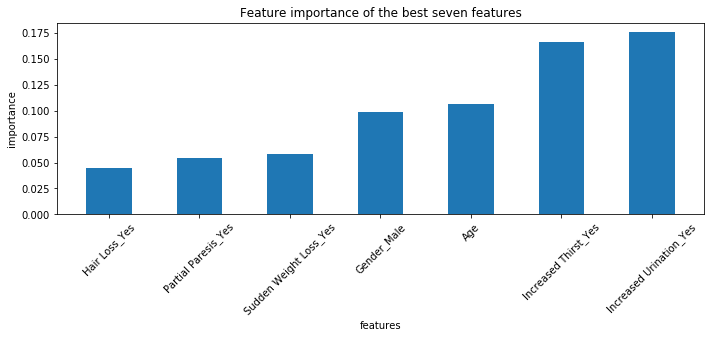

In [15]:
from  matplotlib import pyplot as plt
importance = clf.feature_importances_
# summarize feature importance

df_pvals_labels = list(bin_Xtrain.columns.values)

sorted_labels = [x for _,x in sorted(zip(importance,df_pvals_labels))]

sorted_imp = sorted(importance)

sorted_labels = sorted_labels[10:]
sorted_imp = sorted_imp[10:]
Imp_ft1 = sorted_labels[len(sorted_labels)-1]
Imp_ft2 = sorted_labels[len(sorted_labels)-2]
print(f'The first most important feature is {Imp_ft1}')
print(f'The second most important feature is {Imp_ft2}')
fig = plt.figure(figsize=[10, 4.8])
ax = fig.add_subplot(111)
rects1 = ax.bar([x for x in range(len(importance[10:]))], sorted_imp,
                     align='center', tick_label=sorted_labels, width=0.5)
ax.set_xticklabels(sorted_labels, rotation=45 )
ax.set_title('Feature importance of the best seven features')
ax.set_xlabel('features')
ax.set_ylabel('importance')


#plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In the graph above, we plotted the feature importance using random forest of the seven best features; the two best are 'Increased Urination_Yes' and 'Increased Thirst_Yes'

### YOUR PART, DONE JUST TO CHECK RESULTS / ANSWER QUESTIONS IF NEEDED / INSERT OTHER PLAUSIBLE EXPLANATION SUCH AS 'HADASSA, GO TO SLEEP BECAUSE YOU ARE CURRENTLY WRITING GARBAGE SO IT S PROBABLY TIME TO STOP' (Ok chef)

### 7) Data Separability Visualization

Now we would like to apply a dimensionality reduction on the dataset:

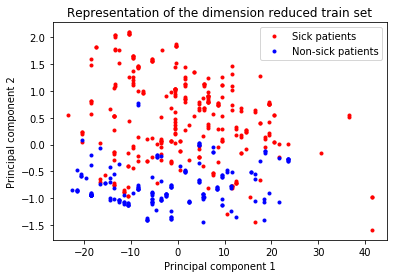

In [17]:
from sklearn.decomposition import PCA

Dim_red = PCA(n_components=2)
Dim_red.fit(bin_Xtrain)
comp = Dim_red.transform(bin_Xtrain).T
y_train = bin_ytrain
pc1 = comp[0]
pc2 = comp[1]
plt.plot(pc1[np.where(y_train==1)[0]],pc2[np.where(y_train==1)[0]], '.', color='r', label="Sick patients")
plt.plot(pc1[np.where(y_train==0)[0]],pc2[np.where(y_train==0)[0]], '.', color='b', label="Non-sick patients")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Representation of the dimension reduced train set')
plt.legend()

In [30]:
new_Xtrain = comp.T
new_Xtest = Dim_red.transform(bin_Xtest)
clf = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(new_Xtrain,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test']
df_scores = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores.loc['Logistic Regression, on train'] = report_performance(clf,new_Xtrain, bin_ytrain)
df_scores.loc['Logistic Regression, on test'] = report_performance(clf,new_Xtest, bin_ytest)
print(df_scores.head(2))

                               F1 score  Accuracy   ROC AUC Log loss
Logistic Regression, on train  0.858223  0.834071  0.925613  4.00238
Logistic Regression, on test   0.863636  0.840708  0.907444  4.66906


Now let's observe the performance with Random forest:

In [31]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=2, 
                             oob_score=best_params_RF['oob_score']).fit(new_Xtrain,bin_ytrain)

df_scores.loc['Random Forest, on train'] = report_performance(clf,new_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Random Forest, on test'] = report_performance(clf,new_Xtest, bin_ytest, type_decision='predict_proba')
print(df_scores.head(4))

                               F1 score  Accuracy   ROC AUC   Log loss
Logistic Regression, on train  0.858223  0.834071  0.925613    4.00238
Logistic Regression, on test   0.863636  0.840708  0.907444    4.66906
Random Forest, on train               1         1         1  0.0467555
Random Forest, on test         0.924242  0.911504  0.977767   0.219718


Now we'll do the same with the best two features of section 6:

In [32]:
Xtrain_2best = bin_Xtrain.loc[:, [Imp_ft1, Imp_ft2]]
Xtest_2best = bin_Xtest.loc[:, [Imp_ft1, Imp_ft2]]
clf = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(Xtrain_2best,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test']
df_scores_2best = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores_2best.loc['Logistic Regression, on train'] = report_performance(clf,Xtrain_2best, bin_ytrain)
df_scores_2best.loc['Logistic Regression, on test'] = report_performance(clf,Xtest_2best, bin_ytest)
print(df_scores_2best.head(2))

                               F1 score  Accuracy   ROC AUC Log loss
Logistic Regression, on train  0.888889  0.867257  0.909466   2.7471
Logistic Regression, on test   0.870968  0.858407  0.883399    4.634


Now let's observe the performance with Random forest:

In [33]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=2, 
                             oob_score=best_params_RF['oob_score']).fit(Xtrain_2best,bin_ytrain)

df_scores_2best.loc['Random Forest, on train'] = report_performance(clf,Xtrain_2best, bin_ytrain, type_decision='predict_proba')
df_scores_2best.loc['Random Forest, on test'] = report_performance(clf,Xtest_2best, bin_ytest, type_decision='predict_proba')

print('Performance scores for the 2 most important features: \n')
print(df_scores_2best.head(4))
print('\nPerformance scores for the 2 principal components using PCA: \n')
print(df_scores.head(4))

Performance scores for the 2 most important features: 

                               F1 score  Accuracy   ROC AUC  Log loss
Logistic Regression, on train  0.888889  0.867257  0.909466    2.7471
Logistic Regression, on test   0.870968  0.858407  0.883399     4.634
Random Forest, on train        0.888889  0.867257  0.909405  0.332022
Random Forest, on test         0.870968  0.858407  0.888011  0.410402

Performance scores for the 2 principal components using PCA: 

                               F1 score  Accuracy   ROC AUC   Log loss
Logistic Regression, on train  0.858223  0.834071  0.925613    4.00238
Logistic Regression, on test   0.863636  0.840708  0.907444    4.66906
Random Forest, on train               1         1         1  0.0467555
Random Forest, on test         0.924242  0.911504  0.977767   0.219718


As we can notice, the two principal components given by dimensionality reduction (PCA) give better performance scores on the test set and very close scores on the train set (the best two features give slightly better results on the train set).

That's all folks!

### Trial with TruncatedSVD (supposed to work better for sparse matrices) -> not better

                               F1 score  Accuracy   ROC AUC Log loss
Logistic Regression, on train  0.854962  0.831858  0.925757  4.09562
Logistic Regression, on test   0.863636  0.840708  0.904809  4.41522
                               F1 score  Accuracy   ROC AUC   Log loss
Logistic Regression, on train  0.854962  0.831858  0.925757    4.09562
Logistic Regression, on test   0.863636  0.840708  0.904809    4.41522
Random Forest, on train               1         1         1  0.0475505
Random Forest, on test         0.924242  0.911504  0.980896   0.210393


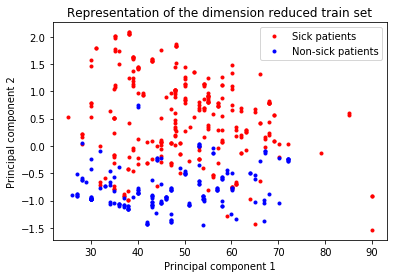

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

Dim_red2 = TruncatedSVD(n_components=2)
Dim_red2.fit(bin_Xtrain)
comp2 = Dim_red2.transform(bin_Xtrain).T
y_train = bin_ytrain
pc1 = comp2[0]
pc2 = comp2[1]
plt.plot(pc1[np.where(y_train==1)[0]],pc2[np.where(y_train==1)[0]], '.', color='r', label="Sick patients")
plt.plot(pc1[np.where(y_train==0)[0]],pc2[np.where(y_train==0)[0]], '.', color='b', label="Non-sick patients")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Representation of the dimension reduced train set')
plt.legend()

new_Xtrain2 = comp2.T
new_Xtest2 = Dim_red2.transform(bin_Xtest)
clf = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(new_Xtrain2,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test']
df_scores = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores.loc['Logistic Regression, on train'] = report_performance(clf,new_Xtrain2, bin_ytrain)
df_scores.loc['Logistic Regression, on test'] = report_performance(clf,new_Xtest2, bin_ytest)
print(df_scores.head(2))

clf = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=2, 
                             oob_score=best_params_RF['oob_score']).fit(new_Xtrain,bin_ytrain)

df_scores.loc['Random Forest, on train'] = report_performance(clf,new_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Random Forest, on test'] = report_performance(clf,new_Xtest, bin_ytest, type_decision='predict_proba')
print(df_scores.head(4))